In [1]:
import pandas as pd
import numpy as np


dataset=pd.read_csv("cleaned_data.csv",index_col=0)
dataset=dataset.dropna()

np.random.seed(10)

random_number=np.random.rand(len(dataset.index.values))

msk1=random_number<0.7
msk2=random_number>0.85
msk3=(random_number>=0.7) & (random_number<=0.85)

train_set=dataset.loc[msk1,:]
test_set=dataset.loc[msk2,:]
validation_set=dataset.loc[msk3,:]

In [2]:
#design the function to resclae the data to adjust the loan amount, interest rate, annual income and earliest credit line
from sklearn import preprocessing

def scale_train_data(df):
    target=['loan_amnt','int_rate','annual_inc','earliest_cre_line']
    new_df=df.loc[:,df.columns.difference(target)]
    loan_amount_scaler=preprocessing.StandardScaler().fit(df[target[0]].reshape(-1, 1))
    new_df['scaled_'+target[0]]=loan_amount_scaler.transform(df[target[0]].reshape(-1, 1))
    
    int_rate_scaler=preprocessing.StandardScaler().fit(df[target[1]].reshape(-1, 1))
    new_df['scaled_'+target[1]]=int_rate_scaler.transform(df[target[1]].reshape(-1, 1))
    
    annual_inc_scaler=preprocessing.StandardScaler().fit(df[target[2]].reshape(-1, 1))
    new_df['scaled_'+target[2]]=annual_inc_scaler.transform(df[target[2]].reshape(-1, 1))
    
    earliest_cre_line_scaler=preprocessing.StandardScaler().fit(df[target[3]].reshape(-1, 1))
    new_df['scaled_'+target[3]]=earliest_cre_line_scaler.transform(df[target[3]].reshape(-1, 1))
    
    return new_df,[loan_amount_scaler,int_rate_scaler,annual_inc_scaler,earliest_cre_line_scaler]

#design the function to apply the scaler onto test and validation set
def apply_scaler(df,scaler_list):
    target=['loan_amnt','int_rate','annual_inc','earliest_cre_line']
    new_df=df.loc[:,df.columns.difference(target)]
    for i in range(len(target)):
        new_df['scaled_'+target[i]]=scaler_list[i].transform(df[target[i]].reshape(-1, 1))
    return new_df

scaled_train_set,scaler_list=scale_train_data(train_set)
scaled_test_set=apply_scaler(test_set,scaler_list)
scaled_validation_set=apply_scaler(validation_set,scaler_list)


/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: r

In [3]:
scaled_train_set.head()

,binary_default,home_own_binary,inq_last_6mths,purpose_binary,term_digit,scaled_loan_amnt,scaled_int_rate,scaled_annual_inc,scaled_earliest_cre_line
1,0,1,5.0,1,6,-1.451746,0.461849,-0.684025,0.144462
2,1,1,2.0,2,3,-1.463594,0.619286,-0.953260,0.492216
4,1,1,0.0,3,6,-1.392501,-0.126828,0.074470,-0.291979
5,1,1,3.0,4,3,-1.155522,-1.219760,-0.593005,0.895538
6,1,1,1.0,5,6,-0.918543,0.619286,-0.426076,0.984592


In [4]:
import tensorflow as tf
import numpy as np

def construct_neural_layer(input_x, layer_nn,name, activation_fnc=None):
    with tf.name_scope(name):
        n_var=int(input_x.get_shape()[1])
        #create random weights
        stddev=2/np.sqrt(n_var)
        w=tf.Variable(tf.truncated_normal((n_var,layer_nn),stddev=stddev),name="weight",dtype=tf.float32)
        b=tf.Variable(tf.zeros([layer_nn]),name="biases",dtype=tf.float32)
        output=tf.add(tf.matmul(input_x,w),b)
        if activation_fnc=="sigmoid":
            return tf.sigmoid(output)
        elif activation_fnc=="relu":
            return tf.nn.relu(output)
        elif activation_fnc=="softmax":
            return tf.nn.softmax(output)
        else:
            return output

/home/ubuntu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
#construct the layers

#set the variables number for two layers
layer1_nn=10
layer2_nn=5

input_x=tf.placeholder(tf.float32,shape=(None,8),name="X")
input_y=tf.placeholder(tf.int32,shape=(None),name="y")
batch_size=50
learning_rate=0.01

hidden1=construct_neural_layer(input_x,layer1_nn,"Hidden_Layer1",activation_fnc="relu")
hidden2=construct_neural_layer(hidden1,layer2_nn,"Hidden_Layer2",activation_fnc="relu")
output=construct_neural_layer(hidden2,2,"Output_Layer")

loss=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=input_y,logits=output))
accuracy=tf.reduce_mean(tf.cast(tf.nn.in_top_k(output,input_y,1),tf.float32))

tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('NN2_no_dropout')

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

accuracy_tracker=pd.DataFrame(None,index=range(len(scaled_train_set.index.values)//batch_size),columns=['Train','Test'])
loss_tracker=pd.DataFrame(None,index=range(len(scaled_train_set.index.values)//batch_size),columns=['Train','Test'])

with tf.Session() as sess:
    init.run()
    
    for iters in range(len(scaled_train_set.index.values)//batch_size):
        X=scaled_train_set.iloc[(iters*batch_size):((iters+1)*batch_size),1:9]
        Y=scaled_train_set.iloc[(iters*batch_size):((iters+1)*batch_size),0]
        opt,train_loss,train_accuracy,summ=sess.run([training_op,loss,accuracy,merged],feed_dict={input_x:X,input_y:Y})
        train_writer.add_summary(summ,iters*batch_size)
        
        test_loss,test_accuracy=sess.run([loss,accuracy],feed_dict={input_x:scaled_test_set.iloc[:,1:9],input_y:scaled_test_set.iloc[:,0]})
        accuracy_tracker.loc[iters,'Train']=train_accuracy
        accuracy_tracker.loc[iters,'Test']=test_accuracy
        loss_tracker.loc[iters,'Test']=test_loss
        loss_tracker.loc[iters,'Train']=train_loss
        
    acc_train=accuracy.eval(feed_dict={input_x:scaled_train_set.iloc[:,1:9],input_y:scaled_train_set.iloc[:,0]})
    acc_test=accuracy.eval(feed_dict={input_x:scaled_test_set.iloc[:,1:9],input_y:scaled_test_set.iloc[:,0]})
    acc_validate=accuracy.eval(feed_dict={input_x:scaled_validation_set.iloc[:,1:9],input_y:scaled_validation_set.iloc[:,0]})
    
    
    sess.close()
    
    print("Train Accuracy is "+str(acc_train))
    print("Test Accuracy is "+str(acc_test))
    print("Validation Accuracy is "+str(acc_validate))
    

Train Accuracy is 0.924357
Test Accuracy is 0.923228
Validation Accuracy is 0.923206


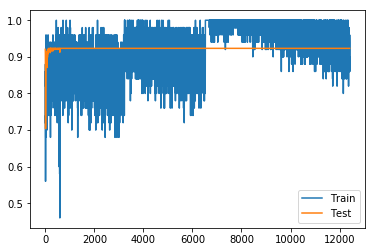

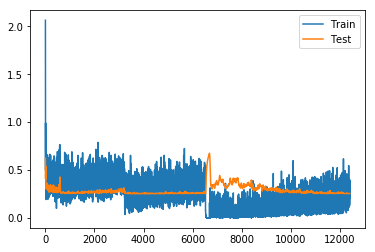

In [6]:
%matplotlib inline
accuracy_tracker.plot();
loss_tracker.plot();